## **70010 - Computational Neurodynamics: Coursework**

---

In [1]:
from iznetwork import IzNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class Small_World_Modular_Net(object):
    """
    This Class simulates a Small World Modular Network of Izhikevich Neurons. 
        - the number of nodes n
        - number of edges m
        - number of modules C
        - probability of rewiring p
    """

    def __init__(self, p, n=1000, C=8, m=1000):
        """
        Initialize the Small World Modular Network with n neurons grouped into C modules, each with m edges, and Network rewiring probability p.
        Inputs:
            - p -- Rewiring Probability
            - n -- Number of total Neurons in the Network (Defaults to 1000). Automatically dives into 80% excitatory and 20% inhibitory neurons.
            - C -- Number of Communities (Defaults to 8)
            - m -- Number of Edges per Module (Defaults to 1000)
        """
        # network parameters
        self._num_neurons = n
        self._D = np.zeros((n, n)) # Delays
        self._W = np.zeros((n, n)) # Weight Connections

        # list of indices of each neuron type
        self._excitatory = [i for i in range(int(n * 0.8))] # indices [0,800) = excitatory neurons
        inhibitory_offset = len(self._excitatory) # 80% of n -> index of first inhibitory neuron
        self._inhibitory = [(i + inhibitory_offset) for i in range(int(n * 0.2))] # indices [800,1000) = excitatory neurons

        # connection matrix --> n x n: each (n_i, n_j) entry represents the directed connection from neuron i to neuron j
        self._connections = np.zeros((n, n))
        neuro_per_module = len(self._excitatory)//C
        self._num_modules = C
        # C communities of n//C excitatory neurons, where each entry (C_k, n_i, n_j) represents the edge from the i-th to the j-th excitatory neurons in k-th community 
        # EG: (2, 6, 84) = 1, if the 307th neuron (2*100 + 6 + 1) conects to the 385th (2*100 + 84 + 1) neuron in the same community (i.e. 7ht -> 85th in the 3rd community)
        #     (2, 6, 84) = 0, otherwise  
        self._communities = np.zeros((self._num_modules, neuro_per_module, neuro_per_module))
        self._set_excitatory(m, neuro_per_module=neuro_per_module)
        self._set_inhibitory(exc_to_inhib=4, neuro_per_module=neuro_per_module)
        # ensure no self-connections
        for i in range(n):
            if self._connections[i, i] != 0:
                # print(f"WARNING: Self connection for neuron {i}")
                self._connections[i, i] = 0
        
        # OPTIONAL: check that all connections are valid based on Coursework Specifications
        self.assert_connections(neuro_per_module=neuro_per_module)

        # rewire connections
        self._p = p # rewiring probability
        self._rewire(p, neuro_per_module=neuro_per_module)

        # scale connections
        self._W = self._scale_connections(self._connections, inhibitory_offset=inhibitory_offset)
        self._set_delays(inhibitory_offset=inhibitory_offset)   

        # create network
        self._net = IzNetwork(N=n, Dmax=50)
        self._net.setDelays(self._D.astype(int))
        self._net.setWeights(self._W)
        a,b,c,d = self._set_params(inhibitory_offset=inhibitory_offset)
        self._net.setParameters(a,b,c,d)

        # (Tasks b,c) Store Fire Behaviour of Network
        self._fired = np.zeros((1000, self._num_neurons))


    def _set_excitatory(self, m, neuro_per_module):
        """
        For each module, set 1000 random directed connections between excitatory neurons within the same community of weight 1.
        Inputs:
            - m -- Number of Edges per Module (Defaults to 1000)
            - neuro_per_module -- Number of (Excitatory) Neurons in each Module
        """
        for module in range(self._num_modules):
            set_edges = 0
            connections = []
            # module offset to represent the neuron in the self._connections matrix: 
            # - in self._communities, the i-th neuron in the module is represented by (module, i), with i in [0, neuro_per_module]
            # - in self._connections, the same neuron in the network is represented by index j, with j=module*neuro_per_module + i
            # EG. neuron 6 in module 2 is represented as (1, 5) in self._communities and 105 in self._connections
            offset = module * neuro_per_module 
            while set_edges < m:
                source_neuro = np.random.randint(0, neuro_per_module)
                target_neuro = np.random.randint(0, neuro_per_module)
                if (source_neuro != target_neuro) and ((source_neuro, target_neuro) not in connections): # ensure no duplicate or self connections
                    self._communities[module, source_neuro, target_neuro] = 1
                    self._connections[source_neuro+offset, target_neuro+offset] = 1
                    connections.append((source_neuro, target_neuro))
                    set_edges += 1


    def _set_inhibitory(self, exc_to_inhib, neuro_per_module):
        """
        Set random directed incoming connections (based on uniform distribution in [0,1]) from excitatory neurons within the same community to each 
        inhibitory neuron. It also sets random directed outgoing connections (based on uniform distribution in [-1,0]) from each inhibitory 
        neuron to all neurons in the network (except itself).
        Inputs:
            - exc_to_inhib -- Number of incoming excitatory edges for each inhibitory neuron
            - neuro_per_module -- Number of (Excitatory) Neurons in each Module
        """
        for inhib in self._inhibitory:
            set_edges = 0
            connections = []
            source_module = np.random.randint(self._num_modules)
            while set_edges < exc_to_inhib:
                start_neuro = source_module * neuro_per_module
                end_neuro = start_neuro + neuro_per_module
                excitatory_source = np.random.randint(start_neuro, end_neuro)
                if (excitatory_source, inhib) not in connections:
                    self._connections[excitatory_source, inhib] = np.random.uniform(0, 1)
                    connections.append((excitatory_source, inhib))
                    set_edges += 1
            self._connections[inhib, :] = np.random.uniform(-1, 0, self._num_neurons) # each inhibitrory neuron connects to every neuron
            self._connections[inhib, inhib] = 0 # except itself


    def _scale_connections(self, connections, inhibitory_offset):
        """ 
        Scale each connection weight based on the type of connection (Excitatory to Excitatory, Excitatory to Inhibitory, 
        Inhibitory to Excitatory). Inhibitory to Inhibitory connections are not scaled (weight=1).
        Inputs:
            - connections -- connection matrix
            - inhibitory_offset -- Index of first inhibitory neuron in the network
        """
        W = np.copy(connections)
        # Apply scaling factor to the weights
        W[:inhibitory_offset, :inhibitory_offset] *= 17 # Excitatory to Excitatory
        W[:inhibitory_offset, inhibitory_offset:] *= 50 # Excitatory to Inhibitory
        W[inhibitory_offset:, :inhibitory_offset] *= 2  # Inhibitory to Excitatory
        return W


    def _set_delays(self, inhibitory_offset):
        """ 
        Set delays based on the type of connection (Excitatory to Excitatory, Excitatory to Inhibitory, 
        Inhibitory to Excitatory and Inhibitory to Inhibitory).
        Inputs:
            - inhibitory_offset -- Index of first inhibitory neuron in the network
        """
        self._D[:inhibitory_offset, :inhibitory_offset] = np.random.randint(1, 20, (inhibitory_offset, inhibitory_offset)) # Excitatory to Excitatory
        self._D[:inhibitory_offset, inhibitory_offset:] = 1 # Excitatory to Inhibitory
        self._D[inhibitory_offset:, :inhibitory_offset] = 1 # Inhibitory to Excitatory
        self._D[inhibitory_offset:, inhibitory_offset:] = 1 # Inhibitory to Inhibitory


    def _rewire(self, p, neuro_per_module):
        """ 
        Rewire each excitatory (to excitatory) connection in each module of the network with probability p. Each rewired
        connection is deleted and replaced by a new connection to a randomly selected excitatory neuron outside the source module.
        Inputs:
            - p -- Rewiring Probability
            - neuro_per_module -- Number of (Excitatory) Neurons in each Module
        """
        # Get the intra connections for each module
        for module in range(self._num_modules):
            offset = module * neuro_per_module
            intra_connection = np.argwhere(self._communities[module] > 0) # Evaluate each existing intra community connection
            for connection in intra_connection:
                if np.random.rand() < p:
                    # Remove the intra connection
                    source_neuro = connection[0]+offset
                    self._connections[connection[0]+offset, connection[1]+offset] = 0
                    self._communities[module, connection[0], connection[1]] = 0
                    # Add a new connection (anything outside the module)
                    target_neuro = np.random.randint(0, len(self._excitatory))
                    target_module = target_neuro // neuro_per_module
                    # if the target neuron is in the same module, keep generating a new neuron
                    while target_module == module:
                        target_neuro = np.random.randint(0, len(self._excitatory))
                        target_module = target_neuro // neuro_per_module

                    # print(f"remove connection from {connection[0]+offset} to {connection[1]+offset}")
                    # print(f"rewire connection from {source_neuro} to {target_neuro} in module {target_module}")
                    self._connections[source_neuro, target_neuro] = 1
    

    def _set_params(self, inhibitory_offset):
        """ 
        Defines a,b,c,d parameters of each Izenkevich neuron based on the type of neuron based on the Lab 2 parameters.
        Inputs:
            - inhibitory_offset -- Index of first inhibitory neuron in the network
        Output:
            - (a,b,c,d) -- Tuple of a,b,c,d matrix parameters
        """
        r = np.random.rand(self._num_neurons)
        a = np.zeros(self._num_neurons)
        a[inhibitory_offset:] = 0.02 + (0.08 * r[inhibitory_offset:]) # inhibitory
        a[:inhibitory_offset] = 0.02 # excitatory 
        b = np.zeros(self._num_neurons)
        b[inhibitory_offset:] = 0.25 - (0.05 * r[inhibitory_offset:]) # inhibitory
        b[:inhibitory_offset] = 0.2 # excitatory 
        c = np.zeros(self._num_neurons)
        c[inhibitory_offset:] = -65 # inhibitory
        c[:inhibitory_offset] = -65 + (15 * (r[:inhibitory_offset] ** 2)) # excitatory 
        d = np.zeros(self._num_neurons)
        d[inhibitory_offset:] = 2 # inhibitory
        d[:inhibitory_offset] = 8 - (6 * (r[:inhibitory_offset] ** 2)) # excitatory 

        return (a,b,c,d)


    def assert_connections(self, neuro_per_module):
        """ 
        Checks if all the network connections (before rewiring) are valid based on the Courework instructions. It checks that:
            - each module has exactly 1000 connections
            - each module has at most 4 outgoing connections to an inhibitory neuron
            - each inhibitory neuron has 4 incoming excitatory connections
            - each inhibitory neuron has connections to every other neuron in the network
            - there are no self-connections for every neuron
        Inputs:
            - neuro_per_module -- Number of (Excitatory) Neurons in each Module
        """
        # based on coursework specificatinos
        intra_edges = 1000
        inhib_offset = 800
        exc_to_inhib = 4
        inhib_to_all = intra_edges-1

        for neuro in range(self._num_neurons):
            module = neuro // neuro_per_module
            if neuro in self._excitatory:
                # assert np.sum(self._connections[neuro, :]) <= intra_edges+exc_to_inhib, f"Too many connections for neuron {neuro}"
                assert np.sum(self._communities[module, :, :]) == intra_edges, f"Number of community connections in community {module} not equal to {intra_edges}"
                assert np.sum(self._communities[module, :, inhib_offset:]) <= 4, f"Too many connections from community {module} to inhibitory neurons"
            elif neuro in self._inhibitory:
                assert np.count_nonzero((self._connections[:inhib_offset, neuro])) == exc_to_inhib, f"Number of incoming excitatory connections for neuron {neuro} not equal to {exc_to_inhib}"
                assert np.count_nonzero((self._connections[neuro, :])) == inhib_to_all, f"Number of outgoing inhibitory connections for neuron {neuro} not equal to {inhib_to_all}"
            assert (self._connections[neuro, neuro] == 0), f"Self connection for neuron {neuro}"
        print(f"All Network Connections are Valid.")


    def simulate_net(self, T=1000):
        """ 
        Simulate the network for 1000ms and store the voltage and firing events for each neuron.
        Inputs:
            - T -- Duration of simulation (Defaults to 1000ms)
        """
        V = np.zeros((T, self._num_neurons))
        # self._fired = np.zeros((T, self._num_neurons))
        for t in range(T):
            I = np.zeros(self._num_neurons)
            # inject extra current I=15 based on a poisson distribution with lambda = 0.01
            I = np.random.poisson(0.01, self._num_neurons)
            I[np.argwhere(I>0)] += 15
            self._net.setCurrent(I)
            fired_ids = self._net.update()
            V[t,:], _ = self._net.getState()
            for id in fired_ids:
                self._fired[t, id] = V[t,id]


    def plot_weights(self, title):
        """ 
        Task a: Plots the weight matrix as a heatmap.
        Inputs:
            - title -- Title of Plot
        """
        # visualize w as heatmap
        N = self._num_neurons
        neuro_per_module = len(self._excitatory)//self._num_modules
        plt.figure(figsize=(8,8))
        sns.heatmap(self._W !=0, cbar=False,)
        # sns.heatmap(W_p[p], cmap='gray')
        plt.xticks(np.arange(0, N, neuro_per_module), np.arange(0, N, neuro_per_module))
        plt.yticks(np.arange(0, N, neuro_per_module), np.arange(0, N, neuro_per_module))
        plt.title(title)
        # plt.savefig('test.png', dpi=500)
        plt.show()


    def plot_raster(self, T=1000):
        """
        Task b: plot the firing behaviour of each neuron during simulation. Each neuron spike is represented 
        as a blue dot at the time t of firing.
        Inputs:
            - T -- Duration of simulation (Defaults to 1000ms)
        """
        inhibitory_offset = len(self._excitatory) # to only plot the excitatory neurons
        neuron_events = []
        for neuron in range(self._fired.shape[1]):
            firing_times = np.where(self._fired[:, neuron] > 0)[0]  # Time indices where neuron has fired
            neuron_events.append(firing_times)
        neuron_indices = []
        firing_times_flat = []
        for neuron, times in enumerate(neuron_events):
            if neuron < inhibitory_offset:
                neuron_indices.extend([neuron] * len(times))
                firing_times_flat.extend(times)

        # Plot the raster plot as a scatter plot 
        plt.figure(figsize=(12, 4))
        plt.scatter(firing_times_flat, neuron_indices, color='blue', s=10, marker='o')
        plt.xlabel('Time (ms)')
        plt.ylabel('Neuron Number')
        plt.title(f'Raster plot for Network with p={self._p}')
        plt.xlim(0, T) 
        plt.ylim(inhibitory_offset, 0)  
        plt.tight_layout()
        plt.show()


    def plot_rolling_mean_per_module(self, T=1000, window=50, shift=20):
        """
        Task c: plot the rolling mean for each module with a window of 50ms. Firing rates are downsampled to obtain the mean by  
        computing the average number of firings in 50ms windows shifted every 20ms (Yields 50 data points for each module).
        Inputs:
            - T -- Duration of simulation (Defaults to 1000ms)
            - window -- window size for rolling mean (Defaults to 50ms)
            - shift -- shift size for rolling mean (Defaults to 20ms)
        """
        time_array = np.arange(0, T, shift)
        neuro_per_module = len(self._excitatory)//self._num_modules # to only plot the excitatory neurons
        plt.figure(figsize=(15, 5))
        for i in range(self._num_modules):
            module = np.arange(i*neuro_per_module, i*neuro_per_module + neuro_per_module)
            mean_firing_rate = np.zeros(window)
            for t in range(window):
                t_real = t * shift
                mean_firing_rate[t] = np.mean(self._fired[t_real-24:t_real+25, module])
            plt.plot(time_array, mean_firing_rate, label=f"Module {i+1}")
        plt.xlabel('Time (ms)')
        plt.ylabel('Mean Firing rate')
        plt.title(f'Rolling Mean Firing Rate for each module in Net with p={self._p}')
        plt.legend()
        plt.show()

In [9]:
# Create networks for each p
p = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
networks_by_p = []
for i in range(len(p)):
    print(f"Network with p={p[i]}")
    networks_by_p.append(Small_World_Modular_Net(p=p[i]))

Network with p=0
All Network Connections are Valid.
Network with p=0.1
All Network Connections are Valid.
Network with p=0.2
All Network Connections are Valid.
Network with p=0.3
All Network Connections are Valid.
Network with p=0.4
All Network Connections are Valid.
Network with p=0.5
All Network Connections are Valid.


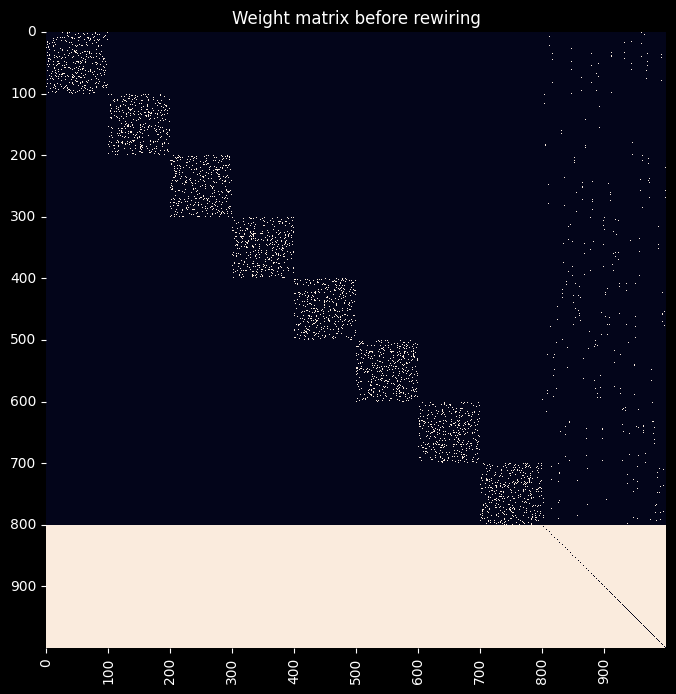

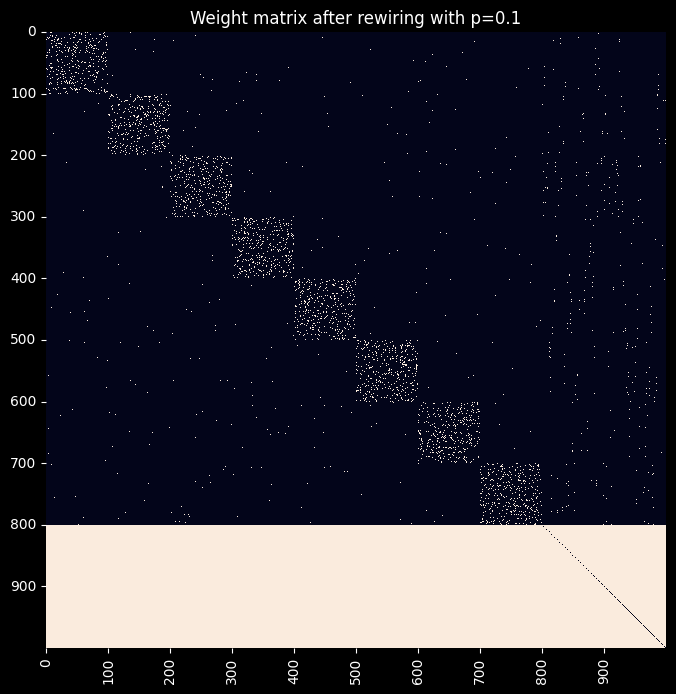

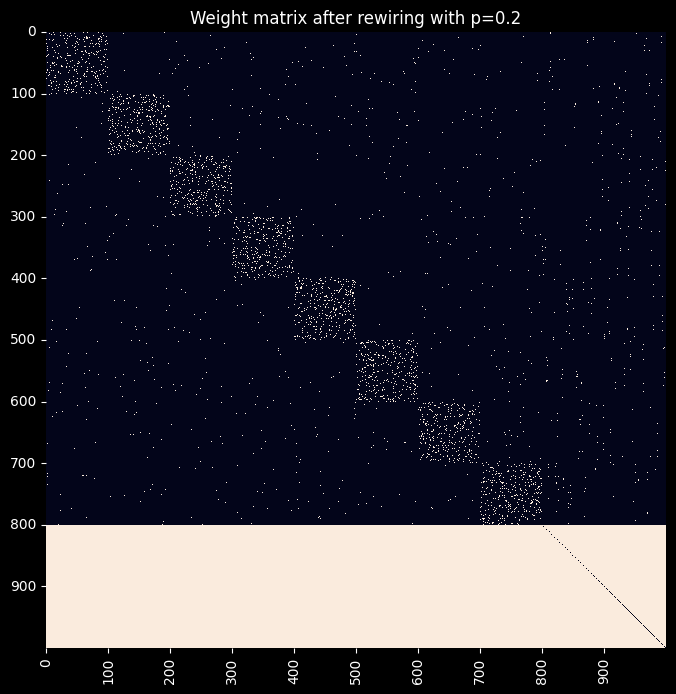

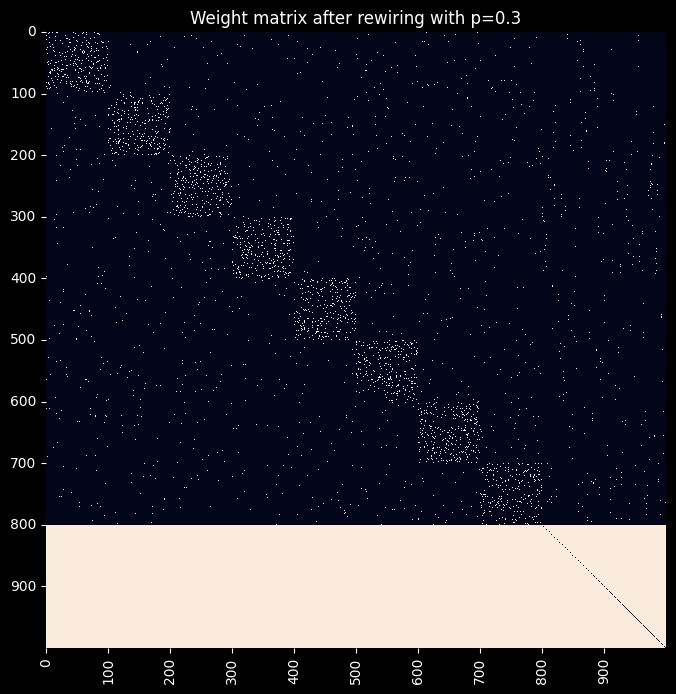

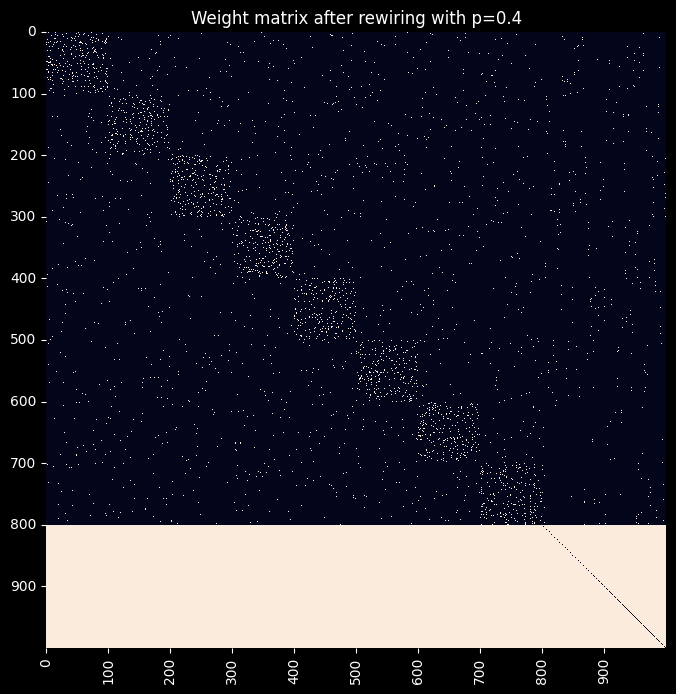

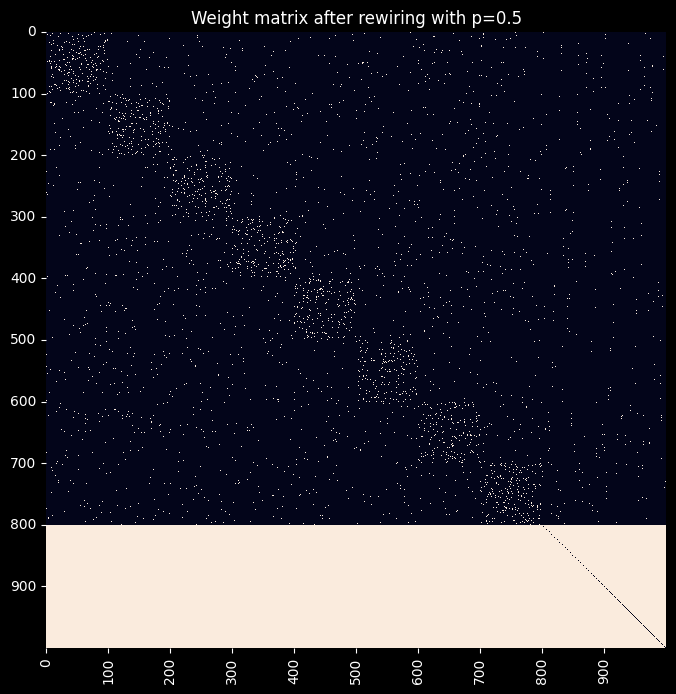

In [10]:
# a) Plot the weight matrix of the network before and after rewiring for each p
for net in networks_by_p:
    if net._p==0.0:
        net.plot_weights("Weight matrix before rewiring")
    else: 
        net.plot_weights(f"Weight matrix after rewiring with p={net._p}")

In [11]:
# Fire network: simulate activity for 1000ms
for net in networks_by_p:
    net.simulate_net(T=1000)

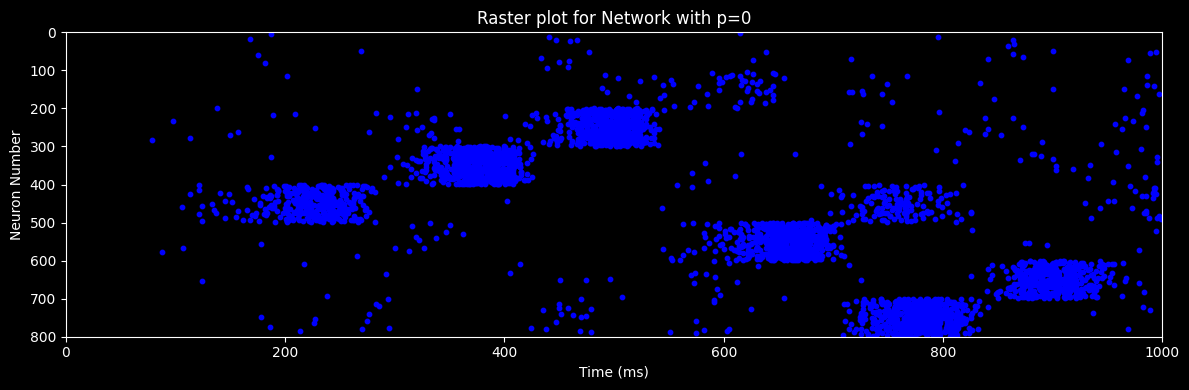

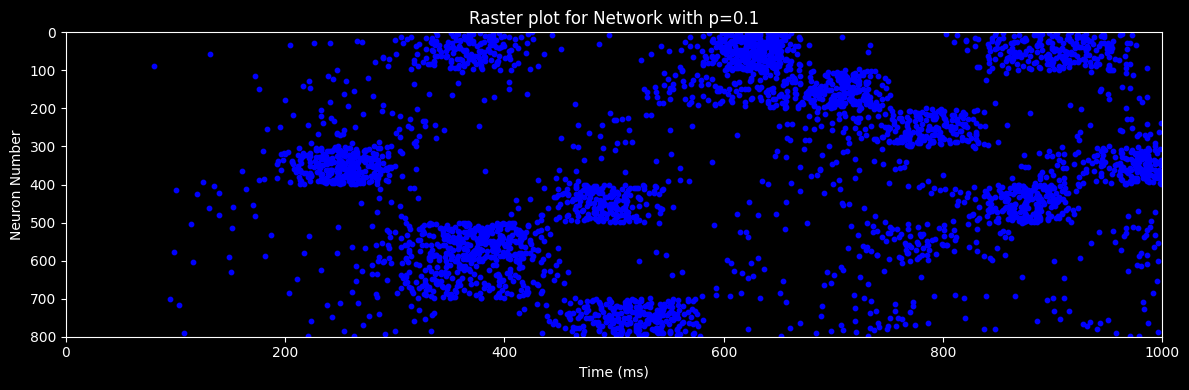

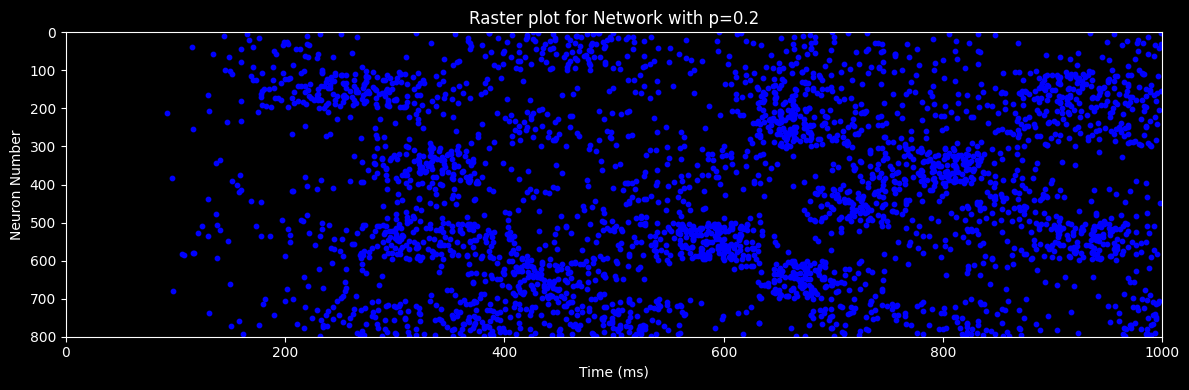

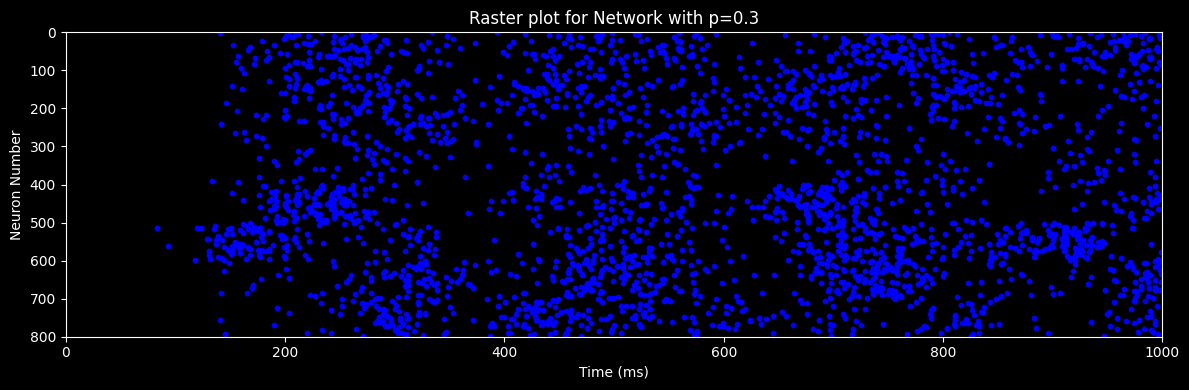

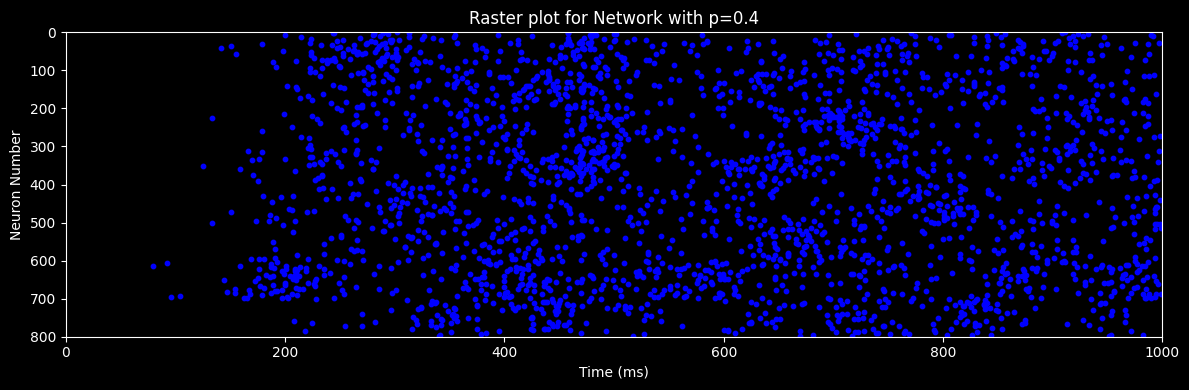

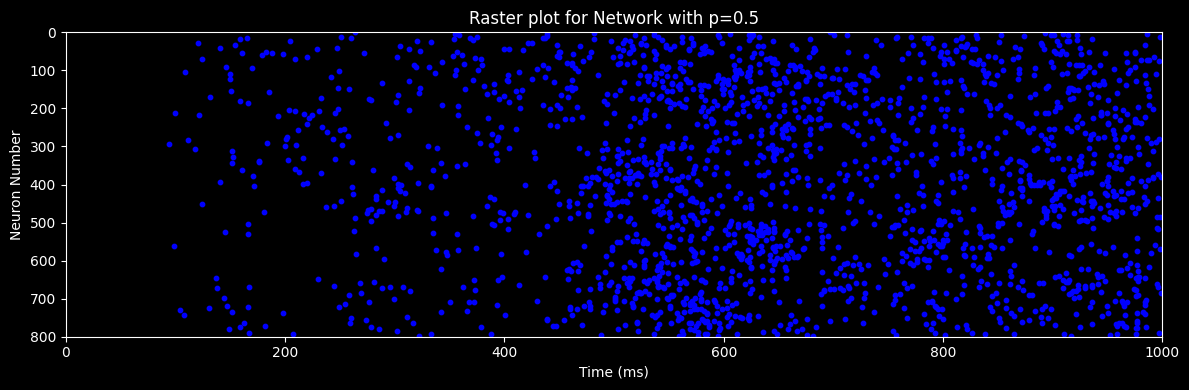

In [12]:
# b) Plot raster plot
for net in networks_by_p:
    net.plot_raster(T=1000)

/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/asiabelfiore/Library/Python/3.9/lib/python/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


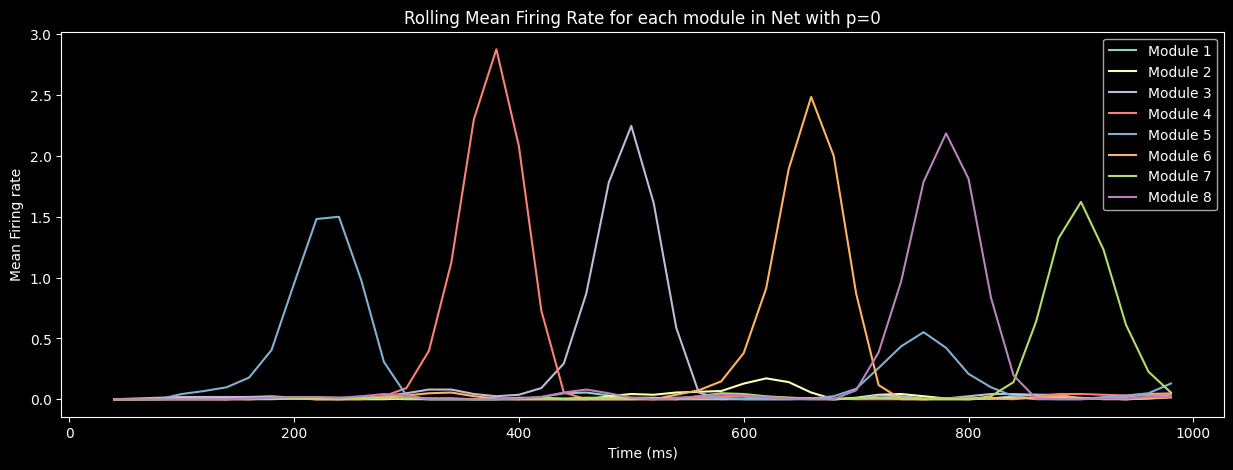

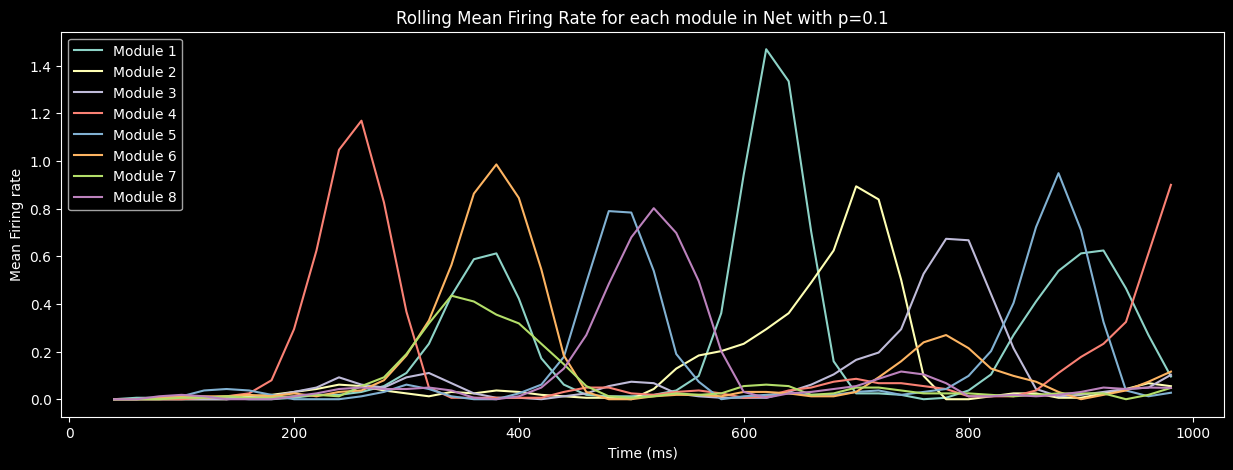

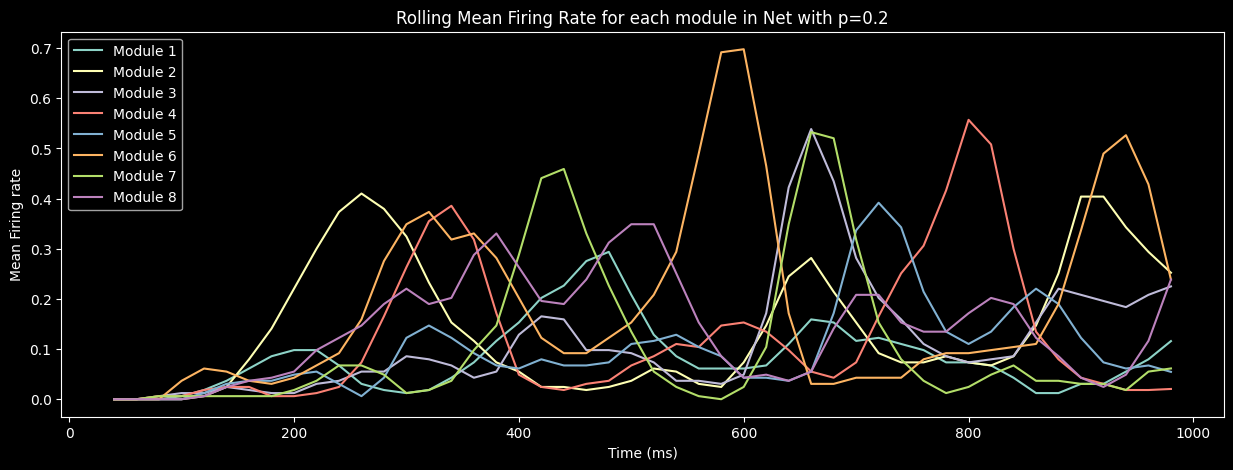

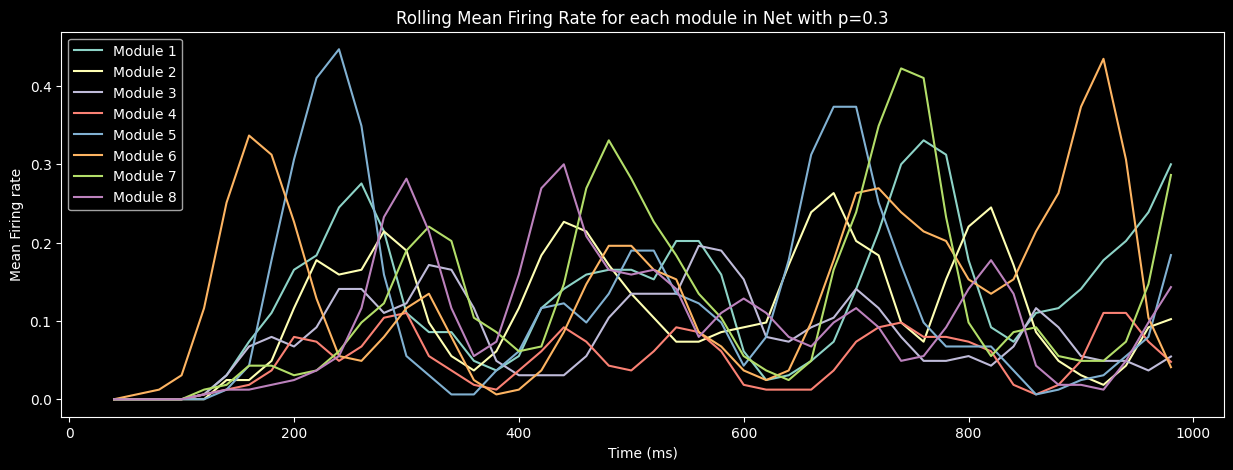

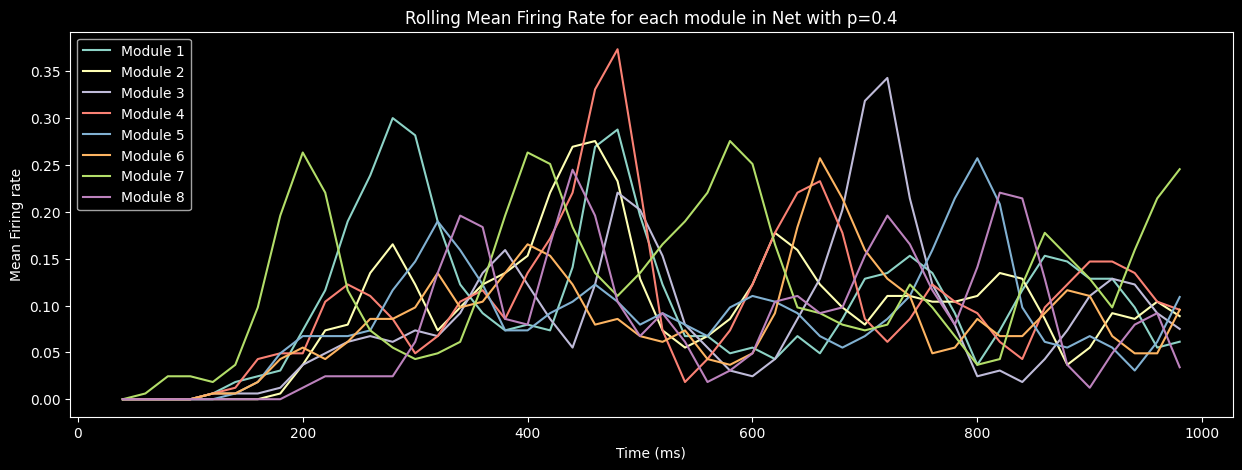

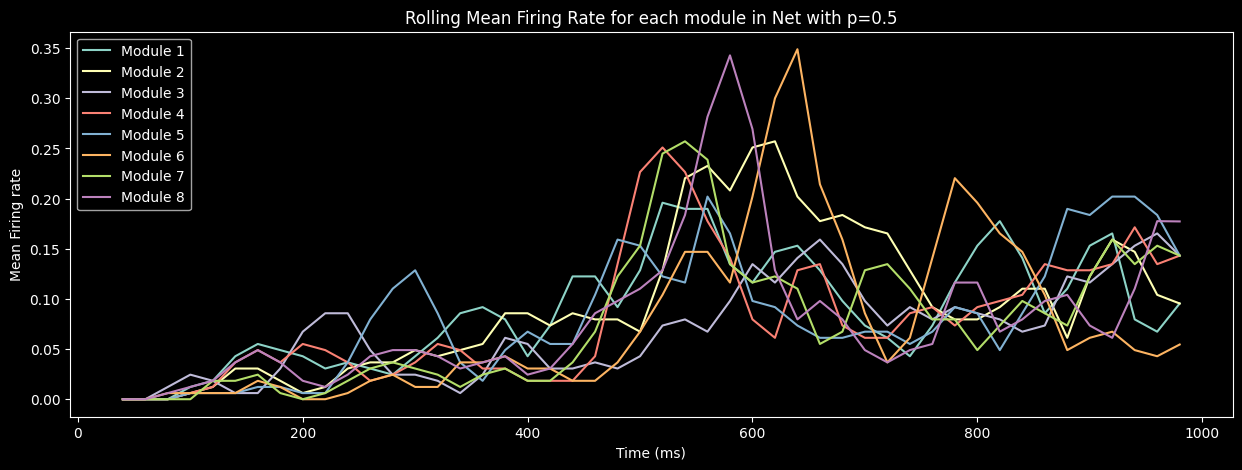

In [13]:
# c) Plot rolling mean for each module
for net in networks_by_p:
    net.plot_rolling_mean_per_module(T=1000)